# Experiment A.i: Reconstructing C. elegans neural activity from three neurons 

Data obtained from $\textit{Global Brain Dynamics Embed the Motor Command Sequence of Caenorhabditis elegans}$. Cell, 163(3), 656–669. http://doi.org/10.1016/j.cell.2015.09.034

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

**Experiment A.i: Reconstruction for each worm**
- randomly select three neurons from the high variance group and reconstruct population-wide activity
- repeated for all five worms. 


In [1]:
# Importing all dependencies 
import numpy as np
import numpy as np
import torch
import subprocess
import os
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random
import mne
from scipy.signal import butter, filtfilt
from scipy.signal import welch
from scipy.interpolate import CubicSpline
from scipy.io import loadmat
from sklearn.linear_model import Ridge


In [2]:
#Importing packages
HOME_DIR = "/Users/amyrude/Downloads/Kutz_Research/SHRED_neuro/neuralSHRED"

SHRED_DIR = os.path.join(HOME_DIR, "sindy-shred-main")
import sys 
sys.path.append(SHRED_DIR)

from processdata import load_data
from processdata import TimeSeriesDataset
import sindy
import pysindy as ps
from pysindy.differentiation import FiniteDifference

os.environ["CUDA_VISIBLE_DEVICES"]="0"


/Users/amyrude/Downloads/Kutz_Research/SHRED_neuro/shredneuro/lib/python3.13/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


# Importing the Data
- 5 worms
- 18 mins at roughly 2.85 samples per second --> ~3000 samples per trial
- 107 - 131 neurons

In [3]:
# Loading the Dataset
os.chdir("../")

data_path = os.path.join(HOME_DIR, 'worms/data/WT_NoStim.mat')
data = loadmat(data_path)
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'WT_NoStim', 'WT_Stim'])


In [4]:
# Working with the no stim condition -- WORM ONE
neuron = 0
no_stim = data['WT_NoStim']
neuron_data = no_stim[0][neuron][0] 
print(neuron_data.shape)
time = no_stim[0][neuron][4]

m = neuron_data.shape[0] # number of timepoints
n = neuron_data.shape[1] #number of neurons 

neuron_data_cor = no_stim[0][neuron][1]

neuron_name = []
for i in range((n-1)):
    neuron_name.append(no_stim[0][neuron][3][0][i][0])

sr = no_stim[0][neuron][6][0][0]
# Movement Classifications;  
# ‘FWD’ forward crawling ‘SLOW’ forward slowing ‘DT’ dorsal post reversal turn ‘VT’ ventral post reversal turn 
# ‘REV1’ reverse crawling ‘REV2’ reverse crawling ‘REVSUS’ sustained reverse crawling ‘NOSTATE’ - ambiguous
FWD = no_stim[0][neuron][7][0][0][0]
SLOW = no_stim[0][neuron][7][0][0][1]
DT = no_stim[0][neuron][7][0][0][2]
VT = no_stim[0][neuron][7][0][0][3]
REV1 = no_stim[0][neuron][7][0][0][4]
REV2 = no_stim[0][neuron][7][0][0][5]
REVSUS = no_stim[0][neuron][7][0][0][6]
NOSTATE = no_stim[0][neuron][7][0][0][7]

print('number timepoints(m)', m, 'number neurons(n):', n)
print('sr', sr, 'Hz')



neuron_one = neuron_data_cor[:1500,:]
time_one = time[:1500].flatten()
neuron_name_one = np.array(neuron_name)
dt_one = time[1][0] - time[0][0]
print(time_one[-1])

(3137, 109)
number timepoints(m) 3137 number neurons(n): 109
sr 2.9046296296296297 Hz
516.0726809053235


In [5]:
# Working with the no stim condition -- WORM TWO
neuron = 1
no_stim = data['WT_NoStim']
neuron_data = no_stim[0][neuron][0]
print(neuron_data.shape)
time = no_stim[0][neuron][4]

m = neuron_data.shape[0] # number of timepoints
n = neuron_data.shape[1] #number of neurons 

neuron_data_cor = no_stim[0][neuron][1]

neuron_name = []
for i in range((n-1)):
    neuron_name.append(no_stim[0][neuron][3][0][i][0])
sr = no_stim[0][neuron][6][0][0]
# Movement Classifications;  
# ‘FWD’ forward crawling ‘SLOW’ forward slowing ‘DT’ dorsal post reversal turn ‘VT’ ventral post reversal turn 
# ‘REV1’ reverse crawling ‘REV2’ reverse crawling ‘REVSUS’ sustained reverse crawling ‘NOSTATE’ - ambiguous
FWD = no_stim[0][neuron][7][0][0][0]
SLOW = no_stim[0][neuron][7][0][0][1]
DT = no_stim[0][neuron][7][0][0][2]
VT = no_stim[0][neuron][7][0][0][3]
REV1 = no_stim[0][neuron][7][0][0][4]
REV2 = no_stim[0][neuron][7][0][0][5]
REVSUS = no_stim[0][neuron][7][0][0][6]
NOSTATE = no_stim[0][neuron][7][0][0][7]

print('number timepoints(m)', m, 'number neurons(n):', n)
print('sr', sr, 'Hz')




neuron_two = neuron_data_cor[:1500,:]
time_two = time[:1500].flatten() 
neuron_name_two = np.array(neuron_name)
dt_two = time[1][0] - time[0][0]
print(time_two[-1])

(3134, 135)
number timepoints(m) 3134 number neurons(n): 135
sr 2.901851851851852 Hz
516.5666879387364


In [6]:
# Working with the no stim condition -- WORM THREE
neuron = 2
no_stim = data['WT_NoStim']
neuron_data = no_stim[0][neuron][0] 
print(neuron_data.shape)
time = no_stim[0][neuron][4]

m = neuron_data.shape[0] # number of timepoints
n = neuron_data.shape[1] #number of neurons 

neuron_data_cor = no_stim[0][neuron][1]

neuron_name = []
for i in range((n-1)):
    neuron_name.append(no_stim[0][neuron][3][0][i][0])

sr = (sr + no_stim[0][neuron][6][0][0])/2
# Movement Classifications;  
# ‘FWD’ forward crawling ‘SLOW’ forward slowing ‘DT’ dorsal post reversal turn ‘VT’ ventral post reversal turn 
# ‘REV1’ reverse crawling ‘REV2’ reverse crawling ‘REVSUS’ sustained reverse crawling ‘NOSTATE’ - ambiguous
FWD = no_stim[0][neuron][7][0][0][0]
SLOW = no_stim[0][neuron][7][0][0][1]
DT = no_stim[0][neuron][7][0][0][2]
VT = no_stim[0][neuron][7][0][0][3]
REV1 = no_stim[0][neuron][7][0][0][4]
REV2 = no_stim[0][neuron][7][0][0][5]
REVSUS = no_stim[0][neuron][7][0][0][6]
NOSTATE = no_stim[0][neuron][7][0][0][7]

print('number timepoints(m)', m, 'number neurons(n):', n)
print('sr', sr, 'Hz')



neuron_three = neuron_data_cor[:1500,:]
time_three = time[:1500].flatten()
neuron_name_three = np.array(neuron_name)
dt_three = time[1][0] - time[0][0]




(3059, 131)
number timepoints(m) 3059 number neurons(n): 131
sr 2.8671296296296296 Hz


In [7]:
# Working with the no stim condition -- WORM FOUR
neuron = 3
no_stim = data['WT_NoStim']
neuron_data = no_stim[0][neuron][0] 
print(neuron_data.shape)
time = no_stim[0][neuron][4]

m = neuron_data.shape[0] # number of timepoints
n = neuron_data.shape[1] #number of neurons 

neuron_data_cor = no_stim[0][neuron][1]

neuron_name = []
for i in range((n-1)):
    neuron_name.append(no_stim[0][neuron][3][0][i][0])

sr = (sr + no_stim[0][neuron][6][0][0])/2
# Movement Classifications;  
# ‘FWD’ forward crawling ‘SLOW’ forward slowing ‘DT’ dorsal post reversal turn ‘VT’ ventral post reversal turn 
# ‘REV1’ reverse crawling ‘REV2’ reverse crawling ‘REVSUS’ sustained reverse crawling ‘NOSTATE’ - ambiguous
FWD = no_stim[0][neuron][7][0][0][0]
SLOW = no_stim[0][neuron][7][0][0][1]
DT = no_stim[0][neuron][7][0][0][2]
VT = no_stim[0][neuron][7][0][0][3]
REV1 = no_stim[0][neuron][7][0][0][4]
REV2 = no_stim[0][neuron][7][0][0][5]
REVSUS = no_stim[0][neuron][7][0][0][6]
NOSTATE = no_stim[0][neuron][7][0][0][7]

print('number timepoints(m)', m, 'number neurons(n):', n)
print('sr', sr, 'Hz')



neuron_four = neuron_data_cor[:1500,:]
time_four = time[:1500].flatten() 
neuron_name_four = np.array(neuron_name)
dt_four = time[1][0] - time[0][0]



(3311, 125)
number timepoints(m) 3311 number neurons(n): 125
sr 2.966435185185185 Hz


In [8]:
# Working with the no stim condition -- WORM FIVE
neuron = 4
no_stim = data['WT_NoStim']
neuron_data = no_stim[0][neuron][0] 
print(neuron_data.shape)
time = no_stim[0][neuron][4]

m = neuron_data.shape[0] # number of timepoints
n = neuron_data.shape[1] #number of neurons 

neuron_data_cor = no_stim[0][neuron][1]

neuron_name = []
for i in range((n-1)):
    neuron_name.append(no_stim[0][neuron][3][0][i][0])

sr = (sr + no_stim[0][neuron][6][0][0])/2
# Movement Classifications;  
# ‘FWD’ forward crawling ‘SLOW’ forward slowing ‘DT’ dorsal post reversal turn ‘VT’ ventral post reversal turn 
# ‘REV1’ reverse crawling ‘REV2’ reverse crawling ‘REVSUS’ sustained reverse crawling ‘NOSTATE’ - ambiguous
FWD = no_stim[0][neuron][7][0][0][0]
SLOW = no_stim[0][neuron][7][0][0][1]
DT = no_stim[0][neuron][7][0][0][2]
VT = no_stim[0][neuron][7][0][0][3]
REV1 = no_stim[0][neuron][7][0][0][4]
REV2 = no_stim[0][neuron][7][0][0][5]
REVSUS = no_stim[0][neuron][7][0][0][6]
NOSTATE = no_stim[0][neuron][7][0][0][7]

print('number timepoints(m)', m, 'number neurons(n):', n)
print('sr', sr, 'Hz')



neuron_five = neuron_data_cor[:1500,:]
time_five = time[:1500].flatten() 
neuron_name_five = np.array(neuron_name)
dt_five = time[1][0] - time[0][0]


(3021, 129)
number timepoints(m) 3021 number neurons(n): 129
sr 2.881828703703704 Hz


## Training a SHRED model on each of the five worms

In [ ]:
######## NEURON ONE ########################################################################################################
# Splitting into high and low variance groups
load_X = neuron_five
name = "five_3"
dt = dt_five
print(load_X.shape)

n_t = load_X.shape[0] # number of timepoints
n_s = load_X.shape[1] #number of neurons 
num_neurons = 3 
lags = 100

latent_dim = 32
poly_order = 1 #ignore
include_sine = False #ignore
library_dim = sindy.library_size(latent_dim, poly_order, include_sine, True) #ignore
# os.chdir("/home/amy/SHRED_neuro/sindy-shred")
import sindy_shred

test_val_size = int(0.2*n_t) 
print(test_val_size)
train_indices = np.arange(0, n_t - lags - test_val_size)
mask = np.ones(n_t - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n_t - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[int(test_val_size/2): test_val_size]
test_indices = valid_test_indices[:int(test_val_size/2)]
# print(valid_indices)
# print(test_indices)

var = np.std(load_X[train_indices], axis = 0)
var_ave = np.mean(var)
neuron_index = np.arange(var.shape[0])
high_ind = np.where(var > var_ave)[0]
low_ind = np.where(var < var_ave)[0]

# Randomly select the neurons to train the SHRED model on
indices = np.random.choice(high_ind.shape[0], size= num_neurons, replace=False) 
neuron_locations = high_ind[indices]
file_path = HOME_DIR
file_path = os.path.join(HOME_DIR, f'worms/data_output/exp_Ai/neuron_loc_{name}.npy')
# file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_Ai/neuron_loc_{name}.npy"
np.save(file_path, neuron_locations)
print('yay!')


sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

### Generate input sequences to a SHRED model
all_data_in = np.zeros((n_t - lags, lags, num_neurons))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, neuron_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

shred = sindy_shred.SINDy_SHRED(num_neurons, n_s, hidden_size=latent_dim, hidden_layers=2, l1=350, l2=400, dropout=0.1,
                                library_dim=library_dim, poly_order=poly_order,
                                include_sine=include_sine, dt=dt, sindy = False, layer_norm=False).to(device)

validation_errors = sindy_shred.fit(shred, train_dataset, valid_dataset, batch_size=128, num_epochs=200,
                                    lr=1e-3, verbose=True, threshold=0.25, patience=5, sindy_regularization=0.0,
                                    optimizer="AdamW", thres_epoch=100)

test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
mse_test = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
print('mse test', mse_test)
train_recons = sc.inverse_transform(shred(train_dataset.X).detach().cpu().numpy())
train_ground_truth = sc.inverse_transform(train_dataset.Y.detach().cpu().numpy())
mse_train = np.linalg.norm(train_recons - train_ground_truth) / np.linalg.norm(train_ground_truth)
print('mse train', mse_train)

file_path = os.path.join(HOME_DIR, f'worms/data_output/exp_Ai/train_recon_{name}.npy')
np.save(file_path, train_recons)

file_path = os.path.join(HOME_DIR, f'worms/data_output/exp_Ai/test_recon_{name}.npy')
np.save(file_path, test_recons)


file_path = os.path.join(HOME_DIR, f'worms/data_output/exp_Ai/train_gt_{name}.npy')
np.save(file_path, train_ground_truth)

file_path = os.path.join(HOME_DIR, f'worms/data_output/exp_Ai/test_gt_{name}.npy')
np.save(file_path, test_ground_truth)


(1500, 129)
300
yay!
1 : tensor(0.0470, grad_fn=<AddBackward0>)
2 : tensor(0.0350, grad_fn=<AddBackward0>)
3 : tensor(0.0341, grad_fn=<AddBackward0>)
4 : tensor(0.0363, grad_fn=<AddBackward0>)
5 : tensor(0.0331, grad_fn=<AddBackward0>)
6 : tensor(0.0348, grad_fn=<AddBackward0>)
7 : tensor(0.0328, grad_fn=<AddBackward0>)
8 : tensor(0.0332, grad_fn=<AddBackward0>)
9 : tensor(0.0323, grad_fn=<AddBackward0>)
10 : tensor(0.0314, grad_fn=<AddBackward0>)
11 : tensor(0.0315, grad_fn=<AddBackward0>)
12 : tensor(0.0310, grad_fn=<AddBackward0>)
13 : tensor(0.0302, grad_fn=<AddBackward0>)
14 : tensor(0.0286, grad_fn=<AddBackward0>)
15 : tensor(0.0292, grad_fn=<AddBackward0>)
16 : tensor(0.0290, grad_fn=<AddBackward0>)
17 : tensor(0.0276, grad_fn=<AddBackward0>)
18 : tensor(0.0280, grad_fn=<AddBackward0>)
19 : tensor(0.0269, grad_fn=<AddBackward0>)
20 : tensor(0.0263, grad_fn=<AddBackward0>)
21 : tensor(0.0277, grad_fn=<AddBackward0>)
22 : tensor(0.0268, grad_fn=<AddBackward0>)
23 : tensor(0.0254, 

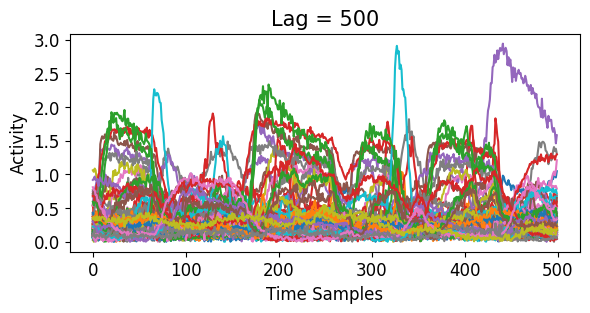

In [78]:
lag = 500
plt.figure(figsize = (6,3))
plt.plot(load_X[:lag,:])
plt.ylabel('Activity', fontsize = 12)
plt.xlabel('Time Samples', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()
plt.title(f'Lag = {lag}', fontsize = 15)
plt.show()


## Plotting the Data

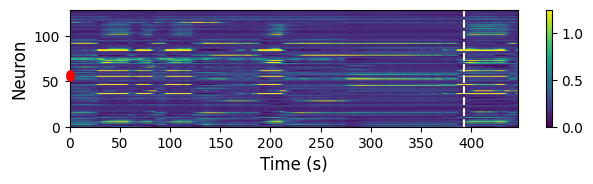

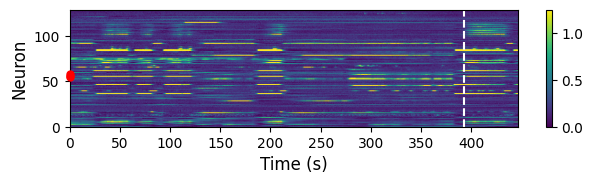

mse train, test [np.float32(0.26169926), np.float32(0.3754778)]
[58 56 55]


In [43]:
name = "five_3" #### change name to one_2, two_2, etc. to plot the results for the different worms
time = time_five[:data.shape[1]]  ### change time_{worm} to corresponding worm 

neuron_loc = np.load(os.path.join(HOME_DIR, f'worms/data_output/exp_Ai/neuron_loc_{name}.npy'))
train = np.load(os.path.join(HOME_DIR, f'worms/data_output/exp_Ai/train_recon_{name}.npy'))
test = np.load(os.path.join(HOME_DIR, f'worms/data_output/exp_Ai/test_recon_{name}.npy'))
data = np.vstack((train, test)).T

fig, ax = plt.subplots(figsize = (6.5,2))
plt.imshow(data, aspect = "auto", extent = [0, time[-1],0,data.shape[0]], vmin = 0, vmax = 1.25)
plt.xlabel('Time (s)', fontsize = 12)
plt.ylabel('Neuron', fontsize =12)
plt.axvline(time[train.shape[0]], color = 'white', linestyle = '--')
# Add red dots for neuron locations on y-axis
for loc in neuron_loc:
    ax.plot(0.1, loc, 'ro', markersize=5, clip_on=False, zorder=10)

plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(HOME_DIR, f'worms/data_output/figs/{name}_recon.png'), transparent = True, dpi = 400)

plt.show()

train_gt = np.load(os.path.join(HOME_DIR, f'worms/data_output/exp_Ai/train_gt_{name}.npy'))
test_gt = np.load(os.path.join(HOME_DIR, f'worms/data_output/exp_Ai/test_gt_{name}.npy'))
data_gt = np.vstack((train_gt, test_gt)).T
fig, ax = plt.subplots(figsize = (6.5,2))
plt.imshow(data_gt, aspect = "auto", extent = [0, time[-1],0,data_gt.shape[0]], vmin = 0, vmax = 1.25)
plt.xlabel('Time (s)', fontsize = 12)
plt.ylabel('Neuron', fontsize = 12)
plt.colorbar()
plt.axvline(time[train.shape[0]], color = 'white', linestyle = '--')
# Add red dots for neuron locations on y-axis
for loc in neuron_loc:
    ax.plot(0.1, loc, 'ro', markersize=5, clip_on=False, zorder=10)
plt.tight_layout()
plt.savefig(os.path.join(HOME_DIR, f'worms/data_output/figs/{name}_gt.png'), transparent = True, dpi = 400)
plt.show()

mask = np.ones(train.shape[0], dtype=bool)
mask[neuron_loc] = False
train_ex = train[mask]
train_gt_ex = train_gt[mask]

mask = np.ones(test.shape[0], dtype=bool)
mask[neuron_loc] = False
test_ex = test[mask]
test_gt_ex = test_gt[mask]

mse_train = np.linalg.norm(train_ex - train_gt_ex) / np.linalg.norm(train_gt_ex)
mse_test = np.linalg.norm(test_ex - test_gt_ex) / np.linalg.norm(test_gt_ex)

print('mse train, test', [mse_train, mse_test])

print(neuron_loc)

In [53]:
# filtering the data
b, a = butter(N=3, Wn=0.01, btype = 'low', fs = sr ) 
filtered_bw = filtfilt(b, a, test_gt, axis =0)
mse_filt = np.linalg.norm(filtered_bw - test_gt) / np.linalg.norm(test_gt)
print(mse_filt)


0.39184700779677767


SMDVR


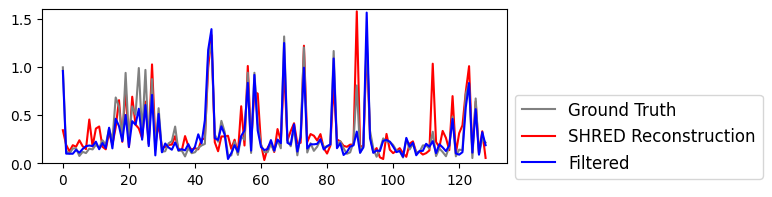

In [59]:
## Plotting the filtered and SHRED reconstruction trace for neuron SMDVR
ind = 43
print(neuron_name_five[ind])

plt.figure(figsize = (6,2))
plt.plot(test_gt[ind, :], color = 'grey', label = "Ground Truth", zorder = 2)
plt.plot(test[ind,:], color = 'red', label = 'SHRED Reconstruction', zorder = 1)
plt.plot(filtered_bw[ind,:], color = 'blue', alpha = 1, label = 'Filtered', zorder = 3)
plt.ylim((0,1.6))
plt.legend(fontsize = 12, bbox_to_anchor=(1, 0.5))
# plt.tight_layout()
# plt.savefig(os.path.join(HOME_DIR, f'worms/data_output/figs/trace_SMDVR.png'), transparent = True, dpi = 400)

# plt.figure(figsize = (6,2))
# plt.plot(test_gt[ind, :1], color = 'grey', label = "Ground Truth")
# plt.plot(test[ind,:1], color = 'red', label = 'SHRED Reconstruction')
# plt.plot(filtered_bw[ind,:], color = 'blue', alpha = 0.5, label = 'Filtered')
# plt.ylim((0,1.6))
# plt.legend(fontsize = 12, bbox_to_anchor=(1, 0.5))
# plt.tight_layout()
# plt.savefig(os.path.join(HOME_DIR, f'worms/data_output/figs/trace_SMDVR_filt.png'), transparent = True, dpi = 400)


Linear Regression Comparison:

[[ 2.00000000e+00  1.07033529e-16 -5.31357242e-17]
 [-1.48641851e-16  2.00000000e+00  5.70731954e-17]
 [ 3.23517794e-16  9.10769428e-16  2.00000000e+00]
 [ 4.00000000e+00  2.14067057e-16 -1.06271448e-16]
 [-2.97283702e-16  4.00000000e+00  1.14146391e-16]
 [ 6.47035588e-16  1.82153886e-15  4.00000000e+00]]
[10. 10. 10. 20. 20. 20.]
(100, 6)


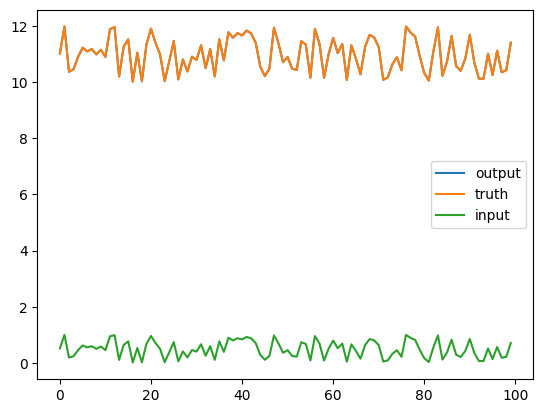

In [60]:
train_in = np.random.rand(3, 100)
train_out_1 = 2*train_in + 10
train_out_2 = 4*train_in+20
train_out = np.concatenate((train_out_1, train_out_2), axis = 0)

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(train_in.T, train_out.T)
print(model.coef_)
print(model.intercept_)

test_in = np.random.rand(3,100)
test_out = model.predict(test_in.T)
print(test_out.shape)
plt.plot(test_out[:,0], label = 'output')
plt.plot(test_in[0,:]*2+10, label = 'truth')
plt.plot(test_in[0,:], label = 'input')

plt.legend()




